In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [5]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 14x14 -> 7x7
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 7x7 -> 14x14
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 14x14 -> 28x28
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
batch_size = 64
learning_rate = 0.001
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model, loss function, and optimizer
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.23MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for data, _ in train_loader:
        data = data.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/10], Loss: 0.0534
Epoch [2/10], Loss: 0.0219
Epoch [3/10], Loss: 0.0179
Epoch [4/10], Loss: 0.0156
Epoch [5/10], Loss: 0.0143
Epoch [6/10], Loss: 0.0133
Epoch [7/10], Loss: 0.0124
Epoch [8/10], Loss: 0.0117
Epoch [9/10], Loss: 0.0112
Epoch [10/10], Loss: 0.0108


In [11]:
model.eval()
with torch.no_grad():
    all_outputs = []
    for data, _ in test_loader:
        data = data.to(device)
        output = model(data)
        all_outputs.append(output.cpu().numpy())

# Flatten the outputs for clustering
flattened_outputs = np.concatenate([out.reshape(out.shape[0], -1) for out in all_outputs], axis=0)


In [13]:

def compute_clustering_loss(latent, kmeans_labels, cluster_centroids):
    loss = 0.0
    latent_np = latent.view(latent.size(0), -1).cpu().detach().numpy()
    
    
    for i in range(latent_np.shape[0]):
        label = kmeans_labels[i]
        centroid = cluster_centroids[label]
        distance = np.linalg.norm(latent_np[i] - centroid)  #euclidean distance
        loss += distance
    
    return loss / latent_np.shape[0]  #avg distance


lambda_val = 0.1
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_clustering_loss = 0.0

    #extract features from the encoder
    model.eval()
    all_latent = []
    for data, _ in train_loader:
        data = data.to(device)
        latent = model.encoder(data)
        
        # Detach the latent tensor from the computation graph before converting to numpy
        all_latent.append(latent.view(latent.size(0), -1).detach().cpu().numpy())  # Detach here

    latent_features = np.concatenate(all_latent, axis=0)

    
    kmeans = KMeans(n_clusters=10, n_init=10)
    kmeans.fit(latent_features)
    cluster_labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_

    
    clustering_loss = compute_clustering_loss(latent, cluster_labels, cluster_centroids)

    
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, data)
        
        total_loss = loss + lambda_val * clustering_loss
        total_loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Clustering Loss: {clustering_loss:.4f}")


Epoch [1/10], Loss: 0.0105, Clustering Loss: 27.2888
Epoch [2/10], Loss: 0.0102, Clustering Loss: 25.6893
Epoch [3/10], Loss: 0.0100, Clustering Loss: 27.7325
Epoch [4/10], Loss: 0.0098, Clustering Loss: 28.5351
Epoch [5/10], Loss: 0.0096, Clustering Loss: 26.3813
Epoch [6/10], Loss: 0.0095, Clustering Loss: 25.1600
Epoch [7/10], Loss: 0.0093, Clustering Loss: 26.8942
Epoch [8/10], Loss: 0.0092, Clustering Loss: 27.7800
Epoch [9/10], Loss: 0.0091, Clustering Loss: 27.3626
Epoch [10/10], Loss: 0.0090, Clustering Loss: 26.5802


In [14]:
from sklearn.decomposition import PCA

In [15]:
silhouette_avg = silhouette_score(latent_features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.0869


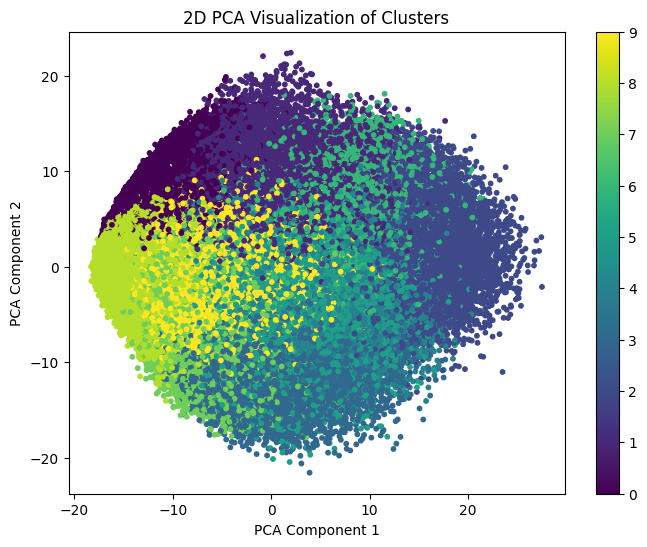

In [16]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar()
plt.title("2D PCA Visualization of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [17]:

print("Cluster Centroids (in latent space):")
print(cluster_centroids)

#output some of the samples from each cluster (first 10 samples of each cluster)
for cluster_idx in range(10):  
    print(f"\nSamples in Cluster {cluster_idx}:")
    cluster_samples = latent_features[cluster_labels == cluster_idx][:10]
    print(cluster_samples)


Cluster Centroids (in latent space):
[[0.94235003 0.05865267 0.058612   ... 0.8763201  0.87978697 0.99674374]
 [0.94242156 0.05864882 0.05780612 ... 0.7864985  0.8786315  0.9968285 ]
 [0.9423289  0.05830584 0.05982806 ... 0.6954274  0.8600184  0.9963498 ]
 ...
 [0.9421555  0.05871184 0.05872411 ... 0.9827392  0.88841957 0.99674416]
 [0.9424304  0.05826709 0.05703507 ... 0.7237343  0.87532395 0.9965107 ]
 [0.94244677 0.05866677 0.05859413 ... 0.8098827  0.8795532  0.99670905]]

Samples in Cluster 0:
[[0.9424514  0.05865434 0.05865434 ... 0.88006765 0.88006765 0.99703985]
 [0.9424514  0.05865434 0.05865434 ... 0.88006765 0.88006765 0.99703985]
 [0.9424514  0.05865434 0.05865434 ... 0.88006765 0.88006765 0.99703985]
 ...
 [0.9424514  0.05865434 0.05865434 ... 0.88006765 0.88006765 0.99703985]
 [0.9424514  0.05865434 0.05865434 ... 0.88006765 0.88006765 0.99703985]
 [0.9424514  0.05865434 0.05865434 ... 0.88006765 0.88006765 0.99703985]]

Samples in Cluster 1:
[[0.9424514  0.05865434 0.058

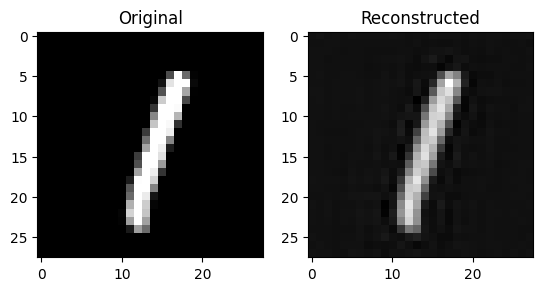

In [12]:

model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = model(data)

        # Show original and reconstructed images
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(data[5].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[0].set_title("Original")
        axes[1].imshow(output[5].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[1].set_title("Reconstructed")
        plt.show()
        break
